In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, TrainLoss: 0.6938058733940125, TrainAccuracy: 0.5014285445213318
Epoch 2, TrainLoss: 0.6931647658348083, TrainAccuracy: 0.5003571510314941
Epoch 3, TrainLoss: 0.6926244497299194, TrainAccuracy: 0.5285714268684387
Epoch 4, TrainLoss: 0.6925264596939087, TrainAccuracy: 0.49964284896850586
Epoch 5, TrainLoss: 0.6924505233764648, TrainAccuracy: 0.4985714554786682
Epoch 6, TrainLoss: 0.6923213601112366, TrainAccuracy: 0.5314285755157471
Epoch 7, TrainLoss: 0.6921036243438721, TrainAccuracy: 0.5782142877578735
Epoch 8, TrainLoss: 0.6920755505561829, TrainAccuracy: 0.5592857599258423
Epoch 9, TrainLoss: 0.6917808055877686, TrainAccuracy: 0.5328571200370789
Epoch 10, TrainLoss: 0.6917865872383118, TrainAccuracy: 0.5274999737739563
Test Loss: 0.6930840015411377, Test Accuracy: 0.5208333134651184
Total time taken to train the model: 88.09157665699968 seconds


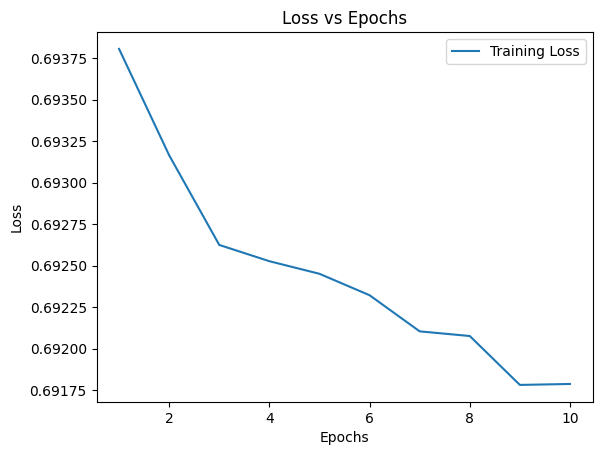

In [ ]:
# pip install torch torchvision matplotlib pillow tqdm torchmetrics


import torch
import torch.nn as nn
from pathlib import Path
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchmetrics as tm

import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from timeit import default_timer as timer
from tqdm.auto import tqdm # progress bar for training loop

import torchvision.transforms as transforms

def walk_directory(path):
    """ Walk through the directory and print the files and directories """
    for root, dirs, files in os.walk(path):
        print(f"Root: {root}")
        print(f"Dirs: {dirs}")
        print(f"number of dirs: {len(dirs)}")
        print(f"Files: {files}")
        print(f"number of files: {len(files)}")
        
path = Path('/kaggle/input/cats-and-dogs-image-classification') 
# walk_directory(path)

imageList= list(path.glob('*/*/*.jpg'))

# len(imageList)

# plt.imshow(Image.open(imageList[0]))

data_transform= transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

train_data= datasets.ImageFolder(
    root='/kaggle/input/cats-and-dogs-image-classification/train',
    transform=data_transform
)

test_data= datasets.ImageFolder(
    root='/kaggle/input/cats-and-dogs-image-classification/test',
    transform=data_transform
)

train_loader= DataLoader(
    dataset=train_data,
    batch_size=8,
    shuffle=True
)

test_loader= DataLoader(
    dataset=test_data,
    batch_size=8,
    shuffle=False
)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1=nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=2,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=8,
                kernel_size=2,
                stride=1,
                padding=1
            ),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8*33*33 , out_features=32*4),
            nn.ReLU(),
            nn.Linear(in_features=32*4, out_features=1)
        )


    def forward(self, x):
        return self.classifier(self.conv_block1(x))


model=Model()
torch.manual_seed(42)

l1=nn.BCEWithLogitsLoss()

optimizer= torch.optim.SGD(model.parameters(), lr= 0.001)
accuracy = tm.Accuracy(task="binary")


def train_time(start, end) :
  total_time= end - start
  print(f'Total time taken to train the model: {total_time} seconds')
  

epochs = 10

epoch_count = []
train_loss_values = []

start_time = timer() 

for epoch in tqdm(range(epochs)):
    
    train_loss = 0 
    train_accuracy=0
    
    for batch, (X, y) in enumerate(train_loader): 
        model.train()
        y_logits = model(X)
        y_pred= torch.round(torch.sigmoid(y_logits)).squeeze(1)
        loss = l1(y_logits, y.unsqueeze(1).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_accuracy += accuracy(y_pred, y.long())
        train_loss += loss
        
    train_loss /= len(train_loader) 
    train_accuracy /= len(train_loader)
    
    print(f'Epoch {epoch+1}, TrainLoss: {train_loss}, TrainAccuracy: {train_accuracy}') 
    
    train_loss_values.append(train_loss)
    epoch_count.append(epoch+1)
 
model.eval()

with torch.inference_mode():
    test_loss = 0 
    test_accuracy=0
    
    for batch, (X, y) in enumerate(test_loader): 
        test_logits = model(X)
        test_pred = torch.round(torch.sigmoid(test_logits)).squeeze(1)
        test_loss += l1(test_logits, y.unsqueeze(1).float())
        test_accuracy += accuracy(test_pred, y.long())
        
    test_loss /= len(test_loader) 
    test_accuracy /= len(test_loader) 
    
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
    
end_time = timer()
train_time(start_time, end_time) 
    
plt.figure()
plt.plot(epoch_count, [loss.detach().numpy() for loss in train_loss_values], label='Training Loss') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()  









